In [115]:
# Cell 1: Load and preprocess data using Pandas DataFrames (modified version)
import numpy as np
import pandas as pd

# Set data directory (modify path if necessary)
datadir = './data/'  # actual data directory

# Load CSV files: read without header; row/column info is obtained from separate files
returns_df = pd.read_csv(datadir + 'US_Returns.csv', header=None)
live_df    = pd.read_csv(datadir + 'US_live.csv', header=None)
dates_df   = pd.read_csv(datadir + 'US_Dates.csv', header=None)  # Date information
names_df   = pd.read_csv(datadir + 'US_Names.csv', header=None)  # Stock names
ff_df      = pd.read_csv(datadir + 'FamaFrench.csv')             # Fama-French data (header present)

# Convert date data: convert the first column to datetime (YYYYMMDD format)
dates = pd.to_datetime(dates_df.iloc[:, 0].astype(str), format='%Y%m%d')

# Extract stock names
names = names_df.iloc[0, :].tolist()

# Assign row and column names to DataFrames
returns_df.index = dates
returns_df.columns = names

live_df.index = dates
live_df.columns = names

# Handle missing values: apply forward fill method
returns_df = returns_df.fillna(method='ffill')
live_df    = live_df.fillna(method='ffill')
ff_df      = ff_df.fillna(method='ffill')

# Post-process live_df:
# For a company that was live (1) at the previous time point but turns dead (0) at the current time,
# set the return at that time to -1 (-100%) and code all subsequent returns as 0.
for col in returns_df.columns:
    # Find the time point when the live status changes from 1 to 0.
    live_series = live_df[col]
    # Condition: previous value is 1 and current value is 0
    death_mask = (live_series.shift(1) == 1) & (live_series == 0)
    
    if death_mask.any():
        # Find the first death date (first index where death_mask is True)
        death_date = death_mask.idxmax()  # returns the index of the first True
        # Set the return at that time to -1 (-100%)
        returns_df.loc[death_date, col] = -1
        # Code all returns after this date as 0
        subsequent_dates = returns_df.index > death_date
        returns_df.loc[subsequent_dates, col] = 0

# Print sample outputs (Jupyter Notebook cell output format)
print("Sample dates:", dates.head())
print("Sample stock names:", names[:5])
print("Some preprocessed returns data:")
print(returns_df.head())

Sample dates: 0   1992-01-03
1   1992-01-10
2   1992-01-17
3   1992-01-24
4   1992-01-31
Name: 0, dtype: datetime64[ns]
Sample stock names: ['1-800-FLOWERS.COM, Inc. Class A', '1st Source Corporation', '21st Century Insurance', 'Radiation Therapy Services Inc.', '24/7 Real Media Inc.']
Some preprocessed returns data:
            1-800-FLOWERS.COM, Inc. Class A  1st Source Corporation  \
0                                                                     
1992-01-03                              NaN                     NaN   
1992-01-10                              NaN                     NaN   
1992-01-17                              NaN                     NaN   
1992-01-24                              NaN                     NaN   
1992-01-31                              NaN                     NaN   

            21st Century Insurance  Radiation Therapy Services Inc.  \
0                                                                     
1992-01-03            4.968900e-02       

In [116]:
# Cell 2: Calculate Standard Momentum Factor using Pandas DataFrame
# For each time t, momentum = (rolling product over 48 weeks of (1 + returns).shift(5)) - 1
momentum_df = (1 + returns_df.shift(5)).rolling(window=48).apply(lambda x: x.prod(), raw=True) - 1

print("Standard Momentum Factor computed. (Momentum DataFrame shape: {})".format(momentum_df.shape))
momentum_df.tail()

Standard Momentum Factor computed. (Momentum DataFrame shape: (1513, 7261))


,"1-800-FLOWERS.COM, Inc. Class A",1st Source Corporation,21st Century Insurance,Radiation Therapy Services Inc.,24/7 Real Media Inc.,"2U, Inc.",360 Communications Company,3Com Corp,3D Systems Corporation,3Dfx Interactive,...,"Accolade, Inc.",MultiPlan Corp Class A,Brookfield Renewable Corporation Class A,Clover Health Investments Corp Class A,"Porch Group, Inc.",Inhibrx Inc,"Annexon, Inc.",Gores Holdings IV Inc Class A,BeyondSpring Inc.,Concentrix Corporation
0,,,,,,,,,,,,,,,,,,,,,
2020-11-27,0.0,0.0,0.0,0.0,0.0,0.608388,0.0,0.0,-0.130990,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-04,0.0,0.0,0.0,0.0,0.0,0.477553,0.0,0.0,-0.334714,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-11,0.0,0.0,0.0,0.0,0.0,0.720322,0.0,0.0,-0.275526,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-18,0.0,0.0,0.0,0.0,0.0,0.483287,0.0,0.0,-0.190573,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-25,0.0,0.0,0.0,0.0,0.0,0.396079,0.0,0.0,-0.171471,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


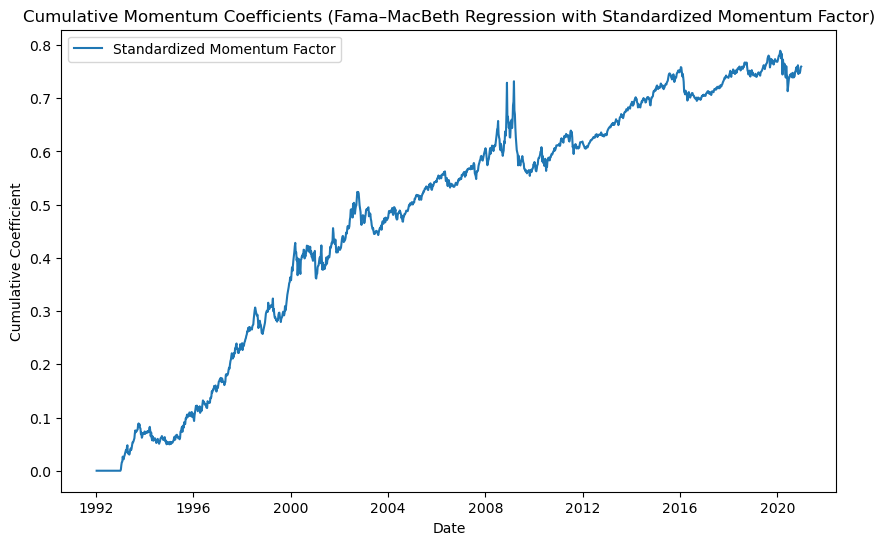

Fama–MacBeth Regression completed. Gamma array shape: (1513, 1)


In [117]:
# Cell 3: Fama–MacBeth Regression using Standardized Momentum Factor
import numpy as np
import matplotlib.pyplot as plt

def standardiseFactor(factorRaw):
    """
    Standardizes the factorRaw (TxN) at each time period using the cross-sectional mean and standard deviation.
    
    INPUTS:
      - factorRaw: (T x N) numpy array (e.g., raw momentum factor)
      
    OUTPUTS:
      - factorStd: (T x N) numpy array, standardized factor values (mean 0, std 1)
    """
    N = factorRaw.shape[1]
    avg = np.tile(np.nanmean(factorRaw, axis=1, keepdims=True), (1, N))
    stdev = np.tile(np.nanstd(factorRaw, axis=1, ddof=1, keepdims=True), (1, N))
    return (factorRaw - avg) / stdev

def famaMacBethMomentumStandardized(returns_df, momentum_df, live_df):
    """
    For each week (t), performs an OLS regression using the one-week ahead returns (y) and the standardized momentum factor (x) from the previous week.
    The regression only includes companies that are live at the time t, and excludes any observation with missing values in either y or x.
    
    The momentum coefficient (beta[1]) from each regression is stored in the gamma array,
    and the regression residuals are stored in the resid array.
    """
    # Convert DataFrames to numpy arrays
    returns = returns_df.to_numpy()    # shape: (T, N)
    momentum = momentum_df.to_numpy()    # shape: (T, N) - raw momentum factor
    live = live_df.to_numpy()            # shape: (T, N)
    
    T, N = returns.shape
    
    # Standardize the momentum factor cross-sectionally at each time period
    momentum_std = standardiseFactor(momentum)
    
    # Convert to a 3-dimensional array: shape (T, N, 1)
    factors = momentum_std[:, :, np.newaxis]
    
    # Initialize arrays to store results
    gamma = np.full((T, 1), np.nan)   # Stores momentum coefficient (beta) for each time period
    resid = np.full((T, N), np.nan)     # Stores regression residuals
    
    # Perform regression: from t = 1 to T-1 (using momentum factor from time t-1)
    for t in range(1, T):
        # Select companies that are live at time t
        live_mask = (live[t] == 1)
        
        # Dependent variable: returns at time t; Independent variable: standardized momentum at time t-1
        y = returns[t]
        x = factors[t-1, :, 0]
        
        # Valid observations: where live status, y, and x are not missing
        valid_mask = (~np.isnan(y)) & (~np.isnan(x)) & live_mask
        
        # Only run regression if there are at least 2 valid observations (including constant term)
        if valid_mask.sum() >= 2:
            y_valid = y[valid_mask]
            x_valid = x[valid_mask]
            # Design matrix: constant term and x_valid
            X_design = np.column_stack((np.ones(len(x_valid)), x_valid))
            
            # OLS regression: y_valid = beta0 + beta1 * x_valid
            beta = np.linalg.lstsq(X_design, y_valid, rcond=None)[0]
            # Save the momentum coefficient (beta1)
            gamma[t, 0] = beta[1]
            # Compute and store the residuals (for valid observations)
            resid_t = y_valid - X_design.dot(beta)
            resid[t, valid_mask] = resid_t
    
    return gamma, resid

# Execute the Fama–MacBeth regression: returns_df, momentum_df, live_df are DataFrames loaded and preprocessed in previous cells
gamma_mom_std, resid_mom_std = famaMacBethMomentumStandardized(returns_df, momentum_df, live_df)

# Plot the cumulative momentum coefficients (gamma) as a time series
cumulative_gamma = np.nancumsum(gamma_mom_std, axis=0)
plt.figure(figsize=(10,6))
plt.plot(dates[1:], cumulative_gamma[1:], label='Standardized Momentum Factor')
plt.title('Cumulative Momentum Coefficients (Fama–MacBeth Regression with Standardized Momentum Factor)')
plt.xlabel('Date')
plt.ylabel('Cumulative Coefficient')
plt.legend()
plt.show()

print("Fama–MacBeth Regression completed. Gamma array shape:", gamma_mom_std.shape)

In [118]:
# Cell 5: Compute the Comomentum Measure (Excluding Industry Adjustment) – Pandas DataFrame Version
import statsmodels.api as sm
from tqdm import tqdm
import numpy as np
import pandas as pd

# ff_factors_df: Fama-French data (aligned to the index of returns_df)
ff_factors_df = ff_df.copy()
ff_factors_df.index = returns_df.index

comomentum_results = []

# Use a rolling window of 52 weeks: start after the first 52 periods (using t-52 ~ t-1)
for current_date in tqdm(returns_df.index[52:], desc="Comomentum Calculation"):
    # Window: the most recent 52 periods (excluding the current period)
    window_dates = returns_df.index[returns_df.index < current_date][-52:]
    if len(window_dates) < 52:
        continue
    window_returns = returns_df.loc[window_dates]
    window_ff = ff_factors_df.loc[window_dates][['Mkt-RF', 'SMB', 'HML']]
    window_ff_const = sm.add_constant(window_ff)
    
    # Select winners/losers based on the momentum value at the current date.
    # If 'factor_df' exists, use it; otherwise, use the previously computed momentum DataFrame (momentum_df)
    momentum_today = factor_df.loc[current_date] if 'factor_df' in globals() else momentum_df.loc[current_date]
    valid_stocks = momentum_today.dropna().index
    # Skip the current date if there are fewer than 10 valid stocks.
    if len(valid_stocks) < 10:
        continue
    # Select the top 10% (at least 1) as winners and the bottom 10% as losers.
    n_select = max(int(np.floor(len(valid_stocks) * 0.1)), 1)
    winners = momentum_today.loc[valid_stocks].sort_values(ascending=False).head(n_select)
    losers = momentum_today.loc[valid_stocks].sort_values(ascending=True).head(n_select)
    
    # --- Winners Group Pooled Regression ---
    winners_returns = window_returns[winners.index]
    n_winners = winners_returns.shape[1]
    if n_winners >= 2:
        # For pooled regression, stack the 52-week returns of each stock into one vector.
        Y_winners = winners_returns.values.flatten()
        # Repeat the same Fama-French design matrix for each stock.
        X_winners = np.tile(window_ff_const.values, (n_winners, 1))
        try:
            beta_winners, _, _, _ = np.linalg.lstsq(X_winners, Y_winners, rcond=None)
        except Exception:
            beta_winners = np.full(window_ff_const.shape[1], np.nan)
        # Predicted values: same for each period (window_ff_const multiplied by beta_winners)
        pred_winners = window_ff_const.values.dot(beta_winners)
        # Compute residuals for each stock: actual returns minus the predicted returns (repeated for each stock)
        residuals_winners = winners_returns.values - np.tile(pred_winners, (n_winners, 1)).T
        if residuals_winners.shape[1] >= 2:
            corr_matrix_winners = np.corrcoef(residuals_winners, rowvar=False)
            mask = np.ones(corr_matrix_winners.shape, dtype=bool)
            np.fill_diagonal(mask, 0)
            corr_winners = np.nanmean(corr_matrix_winners[mask])
        else:
            corr_winners = np.nan
    else:
        corr_winners = np.nan
    
    # --- Losers Group Pooled Regression ---
    losers_returns = window_returns[losers.index]
    n_losers = losers_returns.shape[1]
    if n_losers >= 2:
        Y_losers = losers_returns.values.flatten()
        X_losers = np.tile(window_ff_const.values, (n_losers, 1))
        try:
            beta_losers, _, _, _ = np.linalg.lstsq(X_losers, Y_losers, rcond=None)
        except Exception:
            beta_losers = np.full(window_ff_const.shape[1], np.nan)
        pred_losers = window_ff_const.values.dot(beta_losers)
        residuals_losers = losers_returns.values - np.tile(pred_losers, (n_losers, 1)).T
        if residuals_losers.shape[1] >= 2:
            corr_matrix_losers = np.corrcoef(residuals_losers, rowvar=False)
            mask = np.ones(corr_matrix_losers.shape, dtype=bool)
            np.fill_diagonal(mask, 0)
            corr_losers = np.nanmean(corr_matrix_losers[mask])
        else:
            corr_losers = np.nan
    else:
        corr_losers = np.nan
    
    # Compute the comomentum value as the average of the winners' and losers' residual correlations.
    comom_value = 0.5 * (corr_winners + corr_losers)
    comomentum_results.append((current_date, comom_value))

# Create a DataFrame of results
comomentum_df = pd.DataFrame(comomentum_results, columns=['Date', 'CoMOM']).set_index('Date')
print("Comomentum measurement completed. Sample results:")
print(comomentum_df.head())

Comomentum Calculation: 100%|██████████████████████████████████████████████████████| 1461/1461 [00:20<00:00, 70.11it/s]

Comomentum measurement completed. Sample results:
               CoMOM
Date                
1993-01-01  0.089112
1993-01-08  0.086201
1993-01-15  0.086283
1993-01-22  0.067545
1993-01-29  0.070147


Fama‑MacBeth Regression: 100%|████████████████████████████████████████████████████| 1512/1512 [00:08<00:00, 177.95it/s]


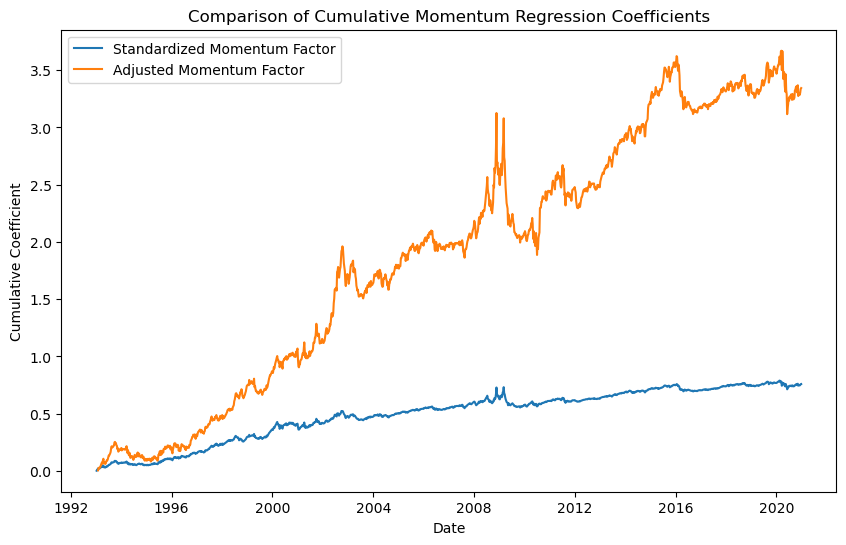

Fama–MacBeth regression (Adjusted Momentum) completed.


In [141]:
# Cell 6: Compute Adjusted Momentum Factor and Fama–MacBeth Regression (Adjusted Momentum) – Pandas DataFrame Version
# Idea:
#  - The current momentum (mom_t) is weighted by (1 - m_t)^1,
#  - The momentum from 1 week ago (mom_t1) is weighted by (1 - m_t1)^2,
#  - The momentum from 2 weeks ago (mom_t2) is weighted by (1 - m_t2)^3,
#  - The momentum from 3 weeks ago (mom_t3) is weighted by (1 - m_t3)^4,
# where m_t is the comomentum value at the corresponding time.
#
# Also, the calculation is performed on the common index between momentum_df and comom_series (i.e., comomentum_df['CoMOM']).

def signed_power(x, exponent):
    """
    Applies the exponent to the absolute value of x while preserving its sign.
    Example: x = -0.5, exponent = 2  -->  - (0.5**2) = -0.25
    """
    return np.sign(x) * (np.abs(x) ** exponent)

# comom_series: Extract the 'CoMOM' column from comomentum_df
comom_series = comomentum_df['CoMOM']

# Extract and sort the common index between momentum_df and comom_series
common_dates = momentum_df.index.intersection(comom_series.index)
common_dates = common_dates.sort_values()

# Create an adjusted momentum DataFrame with the common index
adjusted_momentum_df = pd.DataFrame(index=momentum_df.index, columns=momentum_df.columns, dtype=float)

# Since data from the previous 3 weeks is needed, start the calculation from the 4th common index onward
for i in range(0, len(common_dates)):
    if i < 3:
        continue
    current_date = common_dates[i]
    # Comomentum values for the current and previous 3 weeks
    m_t  = comom_series.loc[current_date]
    m_t1 = comom_series.loc[common_dates[i-1]]
    m_t2 = comom_series.loc[common_dates[i-2]]
    m_t3 = comom_series.loc[common_dates[i-3]]
    
    # Momentum factor values for the current and previous 3 weeks
    mom_t  = momentum_df.loc[current_date]
    mom_t1 = momentum_df.loc[common_dates[i-1]]
    mom_t2 = momentum_df.loc[common_dates[i-2]]
    mom_t3 = momentum_df.loc[common_dates[i-3]]
    
    # Apply decay weights: exponents 1, 2, 3, 4 respectively
    '''
    adjusted_value = ( (1 - m_t)**1   * mom_t   +
                       (1 - m_t1)**2  * mom_t1  +
                       (1 - m_t2)**3  * mom_t2  +
                       (1 - m_t3)**4  * mom_t3 )
    adjusted_value = (
        signed_power(1 - m_t, 1)   * mom_t   +
        signed_power(m_t1 - m_t, 2)  * mom_t1  +
        signed_power(m_t2 - m_t, 3)  * mom_t2  +
        signed_power(m_t3 - m_t, 4)  * mom_t3
    )
    '''

    adjusted_value = (
        signed_power(1 - m_t, 0.5)   * mom_t   +
        signed_power(-m_t1 + m_t, 1)  * mom_t1  +
        signed_power(-m_t2 + m_t, 1.5)  * mom_t2  +
        signed_power(-m_t3 + m_t, 2)  * mom_t3
    )
    
    adjusted_momentum_df.loc[current_date] = adjusted_value

# Remove the initial period where adjusted momentum cannot be computed (if desired)
# adjusted_momentum_df = adjusted_momentum_df.dropna(how='all')

# Perform Fama–MacBeth regression using the adjusted momentum factor.
# The function fama_macbeth_regression_df is assumed to execute the regression using returns_df, the momentum DataFrame, and live_df.
gamma_adjusted_df, residuals_adjusted_df = fama_macbeth_regression_df(returns_df, adjusted_momentum_df, live_df)

# Convert gamma_mom_std (a numpy array) to a pandas DataFrame using the index from returns_df
gamma_mom_std_df = pd.DataFrame(gamma_mom_std, index=returns_df.index, columns=['gamma_std'])

# Extract the start date for the adjusted momentum regression results
start_date_adjusted = gamma_adjusted_df.index[0]

# Select only the data from the standard momentum regression results that occur on or after the start date of the adjusted momentum regression results
gamma_mom_std_aligned = gamma_mom_std_df.loc[gamma_mom_std_df.index >= start_date_adjusted]

plt.figure(figsize=(10,6))
plt.plot(gamma_mom_std_aligned.index, gamma_mom_std_aligned.cumsum(), label='Standardized Momentum Factor')
plt.plot(gamma_adjusted_df.index, gamma_adjusted_df.cumsum(), label='Adjusted Momentum Factor')
plt.title('Comparison of Cumulative Momentum Regression Coefficients')
plt.xlabel('Date')
plt.ylabel('Cumulative Coefficient')
plt.legend()
plt.show()

print("Fama–MacBeth regression (Adjusted Momentum) completed.")

In [142]:
# Cell 7: Compute Annualised Statistics for Factor Return Series
# Here, we calculate annualised mean returns, standard deviations, and Sharpe ratios for 
# both the standard momentum factor and the adjusted momentum factor over the entire sample period.

# Convert gamma_mom_std_df and gamma_adjusted_df to Series (if not already)
gamma_std_series = gamma_mom_std_df['gamma_std'].dropna()
gamma_adj_series = gamma_adjusted_df.squeeze().dropna()

# Assume weekly data; annualisation factors: multiply mean by 52, standard deviation by sqrt(52)
annual_factor = 52

# Standard Momentum Statistics
weekly_mean_std = gamma_std_series.mean()
weekly_std_std = gamma_std_series.std(ddof=1)
annualised_mean_std = weekly_mean_std * annual_factor
annualised_std_std = weekly_std_std * np.sqrt(annual_factor)
sharpe_std = annualised_mean_std / annualised_std_std if annualised_std_std != 0 else np.nan

# Adjusted Momentum Statistics
weekly_mean_adj = gamma_adj_series.mean()
weekly_std_adj = gamma_adj_series.std(ddof=1)
annualised_mean_adj = weekly_mean_adj * annual_factor
annualised_std_adj = weekly_std_adj * np.sqrt(annual_factor)
sharpe_adj = annualised_mean_adj / annualised_std_adj if annualised_std_adj != 0 else np.nan

# Compile the statistics into a DataFrame for easy comparison
stats_df = pd.DataFrame({
    'Annualised Mean': [annualised_mean_std, annualised_mean_adj],
    'Annualised Std': [annualised_std_std, annualised_std_adj],
    'Sharpe Ratio': [sharpe_std, sharpe_adj]
}, index=['Standard Momentum', 'Adjusted Momentum'])

print("Annualised statistics for the factor return series:")
print(stats_df)

Annualised statistics for the factor return series:
                   Annualised Mean  Annualised Std  Sharpe Ratio
Standard Momentum         0.027045        0.048952      0.552472
Adjusted Momentum         0.119328        0.273230      0.436732
